Types of conditions:
- Runs on a schedule 
  - once every week (like boligrafica)
  - 4 times a day (like greenhouse summon)
- Runs if it has detected updated data (if new data, run)
  - Like NOAA data in GHD

In [1]:
import os
import pandas as pd
import numpy as np
from IPython import get_ipython

# envs
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
def NEW_DATA_RUNNER():
    
    return

In [3]:
os.getcwd()

'/home/runner/work/update/update'

starting to check:  BoliGrafica/_bots/twitter_covid_replies/covid_reply.ipynb
previous log found: 2022-08-19 08:26
difference in execution is: 0.3376 days
needed difference to execute: 0.25 days
Executtion:  True ... STARTING NOW
envs failed to load
departamentos:  ['Chuquisaca', 'La Paz', 'Cochabamba', 'Oruro', 'Potosí', 'Tarija', 'Santa Cruz', 'Beni', 'Pando']
tipos:  ['casos' 'decesos' 'positividad' 'pruebas' 'internacion' 'uci' 'uti'
 'primera' 'segunda' 'tercera' 'unica' 'anual']
Datos de COVID-19 y vacunación: Chuquisaca 🤖
Starting success list []
MESSAGE:  Datos de COVID-19 y vacunación: Santa Cruz 🤖
 > Searching for 10 tweets containing "Santa Cruz covid bolivia"
 > found 9 tweets
 > days of invalidity: 10
 > Number of invalids: 20
 > 8 usernames filtered out
 > retweets removed: 0


findfont: Font family ['Manjari'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Manjari'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Manjari'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Manjari'] not found. Falling back to DejaVu Sans.


 > saved and selected 1 images
 > TWEET SUCCESSFUL!!


,tweet_id,reply_datetime,username
0,1556630721808179200,2022-08-12 16:36:18.045948,LaRazon_Bolivia
1,1557933100889509890,2022-08-12 16:41:48.662788,correodelsurcom
2,1557575190418178048,2022-08-12 16:50:48.963902,grupoeldeber
3,1554909488070725634,2022-08-12 17:07:00.969953,ejutv
4,1557732226682716160,2022-08-12 23:20:01.256899,TARIJA200
5,1557720631579668480,2022-08-13 08:25:29.353210,MoneyBolivia
6,1557380770079117313,2022-08-13 16:27:06.412265,elperiodico_bol
7,1558489127145709568,2022-08-13 23:19:56.301634,falloutgirl313
8,1556671138553544706,2022-08-14 08:23:54.570509,ahora_elpueblo
9,1557733001462591488,2022-08-14 16:27:54.406885,ReporteChacoBo


success list: [True] 





 FINISHED WHILE LOOP


findfont: Font family ['Manjari'] not found. Falling back to DejaVu Sans.


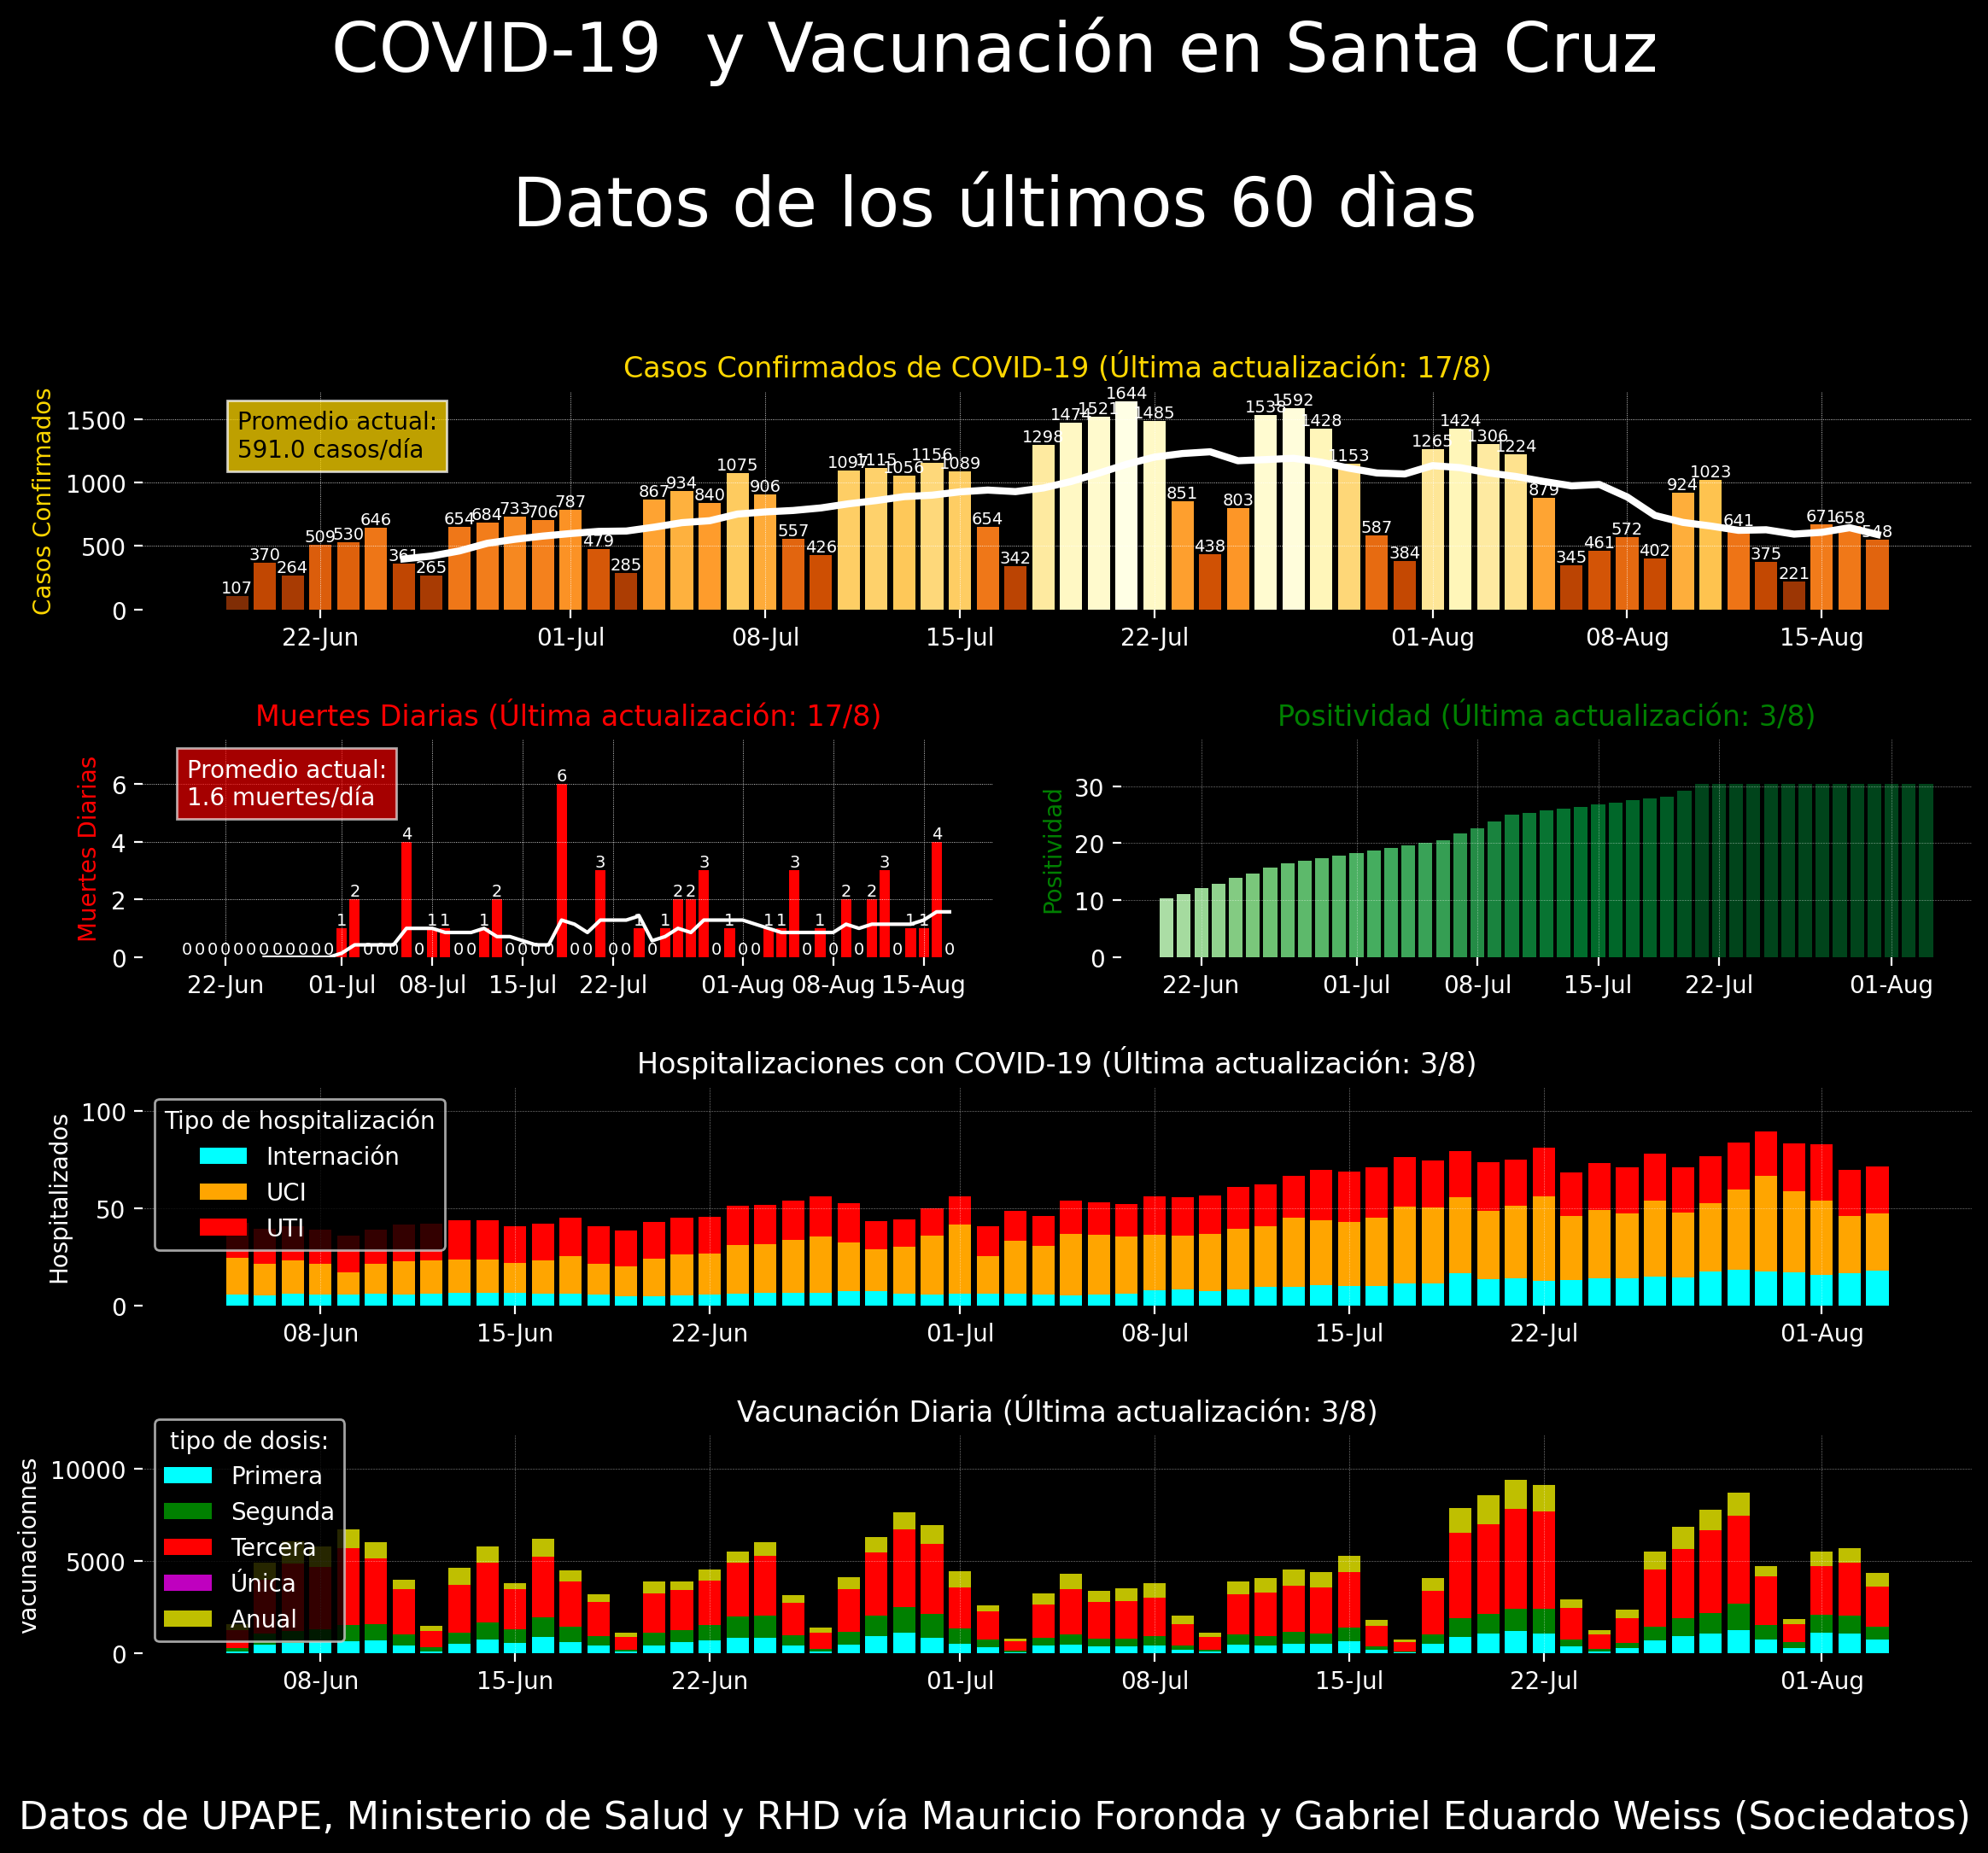

... t'was a SUCCESS! :)
New log entry successful!


Finished:  BoliGrafica/_bots/twitter_covid_replies/covid_reply.ipynb 














😋😋😋😋😋😋😋😋 NEXT 😋😋😋😋😋😋😋😋😋











starting to check:  Greenhouse_Data/_bots/twitter_country_post/country_of_the_day.ipynb
previous log found: 2022-08-19 08:26
difference in execution is: 0.3377 days
needed difference to execute: 1 days
Executtion:  False ... DID NOT EXECUTE NOR LOG
Finished:  Greenhouse_Data/_bots/twitter_country_post/country_of_the_day.ipynb 














😋😋😋😋😋😋😋😋 NEXT 😋😋😋😋😋😋😋😋😋











starting to check:  Greenhouse_Data/_bots/twitter_greenhouse_summon/greenhouse_summon.ipynb
previous log found: 2022-08-19 08:26
difference in execution is: 0.3377 days
needed difference to execute: 0.2083 days
Executtion:  True ... STARTING NOW
envs failed to load
Iran, Islamic Republic of greenhouse gas emission data and figures 👇

If you like this kind of stuff be sure to check out my website for many more datasets and figures! Thank you and ha

/opt/hostedtoolcache/Python/3.9.13/x64/lib/python3.9/site-packages/tweepy/auth.py:120: DeprecationWarning: OAuthHandler is deprecated; use OAuth1UserHandler instead.
  warnings.warn(


 > found 0 tweets
 > empty df: NEXT ITERATION

Starting success list []
 > Searching for 20 tweets containing "greenhouse gas emissions Seychelles"
 > found 0 tweets
 > empty df: NEXT ITERATION

Starting success list []
 > Searching for 20 tweets containing "greenhouse gas emissions Germany"
 > found 11 tweets
 > days of invalidity: 20
 > Number of invalids: 74
 > 0 usernames filtered out
 > retweets removed: 5


['country_data/DEU_Germany/figures/DEU_relative_totals.png',
 'country_data/DEU_Germany/figures/DEU_GCP_Country_Highlight.png',
 'country_data/DEU_Germany/figures/DEU_GCP_1.png',
 'country_data/DEU_Germany/figures/DEU_Minx_top20_subsectors.png']

 > saved and selected 4 images
 > TWEET SUCCESSFUL!!
success list: [True] 



Starting success list [True]
 > Searching for 20 tweets containing "greenhouse gas emissions Croatia"
 > found 0 tweets
 > empty df: NEXT ITERATION

Starting success list [True]
 > Searching for 20 tweets containing "greenhouse gas emissions Central African Republic"
 > found 0 tweets
 > empty df: NEXT ITERATION

Starting success list [True]
 > Searching for 20 tweets containing "greenhouse gas emissions North Korea"
 > found 0 tweets
 > empty df: NEXT ITERATION

Starting success list [True]
 > Searching for 20 tweets containing "greenhouse gas emissions New Caledonia"
 > found 0 tweets
 > empty df: NEXT ITERATION

Starting success list [True]
 > Searching for 20 tweets containing "greenhouse gas emissions Comoros"
 > found 0 tweets
 > empty df: NEXT ITERATION

Starting success list [True]
 > Searching for 20 tweets containing "greenhouse gas emissions Paraguay"
 > found 0 tweets
 > empty df: NEXT ITERATION



['country_data/KEN_Kenya/figures/KEN_relative_totals.png',
 'country_data/KEN_Kenya/figures/KEN_GCP_Country_Highlight.png',
 'country_data/KEN_Kenya/figures/KEN_GCP_1.png',
 'country_data/KEN_Kenya/figures/KEN_Minx_top20_subsectors.png']

 > saved and selected 4 images
 > TWEET SUCCESSFUL!!
success list: [True, True] 





 FINISHED WHILE LOOP


 FINISHED WHILE LOOP
... t'was a SUCCESS! :)
New log entry successful!


Finished:  Greenhouse_Data/_bots/twitter_greenhouse_summon/greenhouse_summon.ipynb 














😋😋😋😋😋😋😋😋 NEXT 😋😋😋😋😋😋😋😋😋











starting to check:  Greenhouse_Data/random_fig/random_fig.ipynb
previous log found: 2022-08-19 08:26
difference in execution is: 0.3379 days
needed difference to execute: 1 days
Executtion:  False ... DID NOT EXECUTE NOR LOG
Finished:  Greenhouse_Data/random_fig/random_fig.ipynb 














😋😋😋😋😋😋😋😋 NEXT 😋😋😋😋😋😋😋😋😋











starting to check:  Greenhouse_Data/NOAA_updates/NOAA_updates.ipynb
previous log found: 2022-08-18 23:33
difference in execution is: 0.708 days
needed difference to execute: 2 days
Executtion:  False ... DID NOT EXECUTE NOR LOG
Finished:  Greenhouse_Data/NOAA_updates/NOAA_updates.ipynb 














😋😋😋😋😋😋😋😋 NEXT 😋😋😋😋😋😋😋😋😋











🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻

In [4]:
def SCHEDULED_RUNNER(notebook_path, schedule_in_days = None):
    
    print("starting to check: ", notebook_path)
    


    # if there is no schedule, run immediately
    if schedule_in_days == None:
        EXECUTE = True
        


    # else run on a schedule based on last execution time
    else:
        # check log
        log = pd.read_csv("log.csv", index_col=0)
        try:
            last_executed = log.loc[notebook_path]["last_executed"]
            print(f"previous log found: {last_executed}")
        except:
            print("no log found (first time?) - creating dummy entry (year 2000)")
            log.loc[notebook_path] = ["2002-07-16 18:32",np.nan]
            
            # try again
            last_executed = log.loc[notebook_path]["last_executed"]
            
        # get time difference in days
        import datetime
        now = datetime.datetime.now()
        last_executed = datetime.datetime.strptime(last_executed, '%Y-%m-%d %H:%M')
        diff_seconds = now - last_executed
        diff_days = diff_seconds.total_seconds() / 60 /60 /24
        print(f"difference in execution is: {round(diff_days,4)} days")
        print(f"needed difference to execute: {round(schedule_in_days,4)} days")
        
        # check diff
        if diff_days > schedule_in_days:
            EXECUTE = True
        else:
            EXECUTE = False
            




    # EXECUTE?


    # EXECUTE TRUE
    if EXECUTE == True:
        print("Executtion: ", str(EXECUTE), "... STARTING NOW")

        # go to folder to run script locally
        folder_path = notebook_path.split("/")[:-1]
        os.chdir("/".join(folder_path))

        # try to run script, if it fails, it fails
        try:
            get_ipython().run_line_magic("run", notebook_path.split("/")[-1])
            status = "... t'was a SUCCESS! :)"
            print(status)
        except:
            status = "... t'was a FAILURE. :("
            print(status)

        # go back to root repository
        os.chdir("".join(["../"] * len(folder_path)))
        
        
        # log
        log.loc[notebook_path] = [datetime.datetime.now().strftime("%Y-%m-%d %H:%M"), status]
        log.to_csv("log.csv")
        print("New log entry successful!\n\n")




    # EXECUTE FALSE
    elif EXECUTE == False:
        print("Executtion: ", str(EXECUTE), "... DID NOT EXECUTE NOR LOG")



    print("Finished: ", notebook_path, "\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n😋😋😋😋😋😋😋😋 NEXT 😋😋😋😋😋😋😋😋😋\n\n\n\n\n\n\n\n\n\n\n")
    pass




########################################################
###################### SCHEDULE #######################
########################################################




# ##### BOLIGRAFICA #####
SCHEDULED_RUNNER(notebook_path = "BoliGrafica/_bots/twitter_covid_replies/covid_reply.ipynb", schedule_in_days= 6/24)


###### GREENHOUSE DATA #####
SCHEDULED_RUNNER(notebook_path = "Greenhouse_Data/_bots/twitter_country_post/country_of_the_day.ipynb", schedule_in_days= 1)    
SCHEDULED_RUNNER(notebook_path = "Greenhouse_Data/_bots/twitter_greenhouse_summon/greenhouse_summon.ipynb", schedule_in_days= 5/24)    
SCHEDULED_RUNNER(notebook_path = "Greenhouse_Data/random_fig/random_fig.ipynb", schedule_in_days= 1)    
SCHEDULED_RUNNER(notebook_path = "Greenhouse_Data/NOAA_updates/NOAA_updates.ipynb", schedule_in_days= 2)


print("🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻 FINITO 🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻\n🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻\n🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻\n🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻\n")